**Word Embedding**

In [1]:
import pandas as pd
df= pd.read_csv('twitter_training.csv')
df_new= df[~df.iloc[:,2].isin(['Neutral', 'Irrelevant'])]

In [2]:
categories = df_new.iloc[:, 2].tolist()
reviews= df_new.iloc[:, 3].tolist()
reviews= [str(doc) if pd.notna(doc) else '' for doc in reviews]
print(set(categories))

{'Negative', 'Positive'}


In [3]:
# 데이터 전처리
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# 영어 불용어와 토크나이저 설정
english_stops = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

# 리뷰 전처리 함수
def preprocess_reviews(reviews):
    processed_reviews = []
    for review in reviews:
        if isinstance(review, str):  # 리뷰가 문자열인지 확인
            tokens = tokenizer.tokenize(review.lower())  # 토큰화
            filtered_words = [word for word in tokens if word not in english_stops]  # 불용어 제거
            processed_reviews.append(filtered_words)  # 토큰화된 단어 리스트 추가
        else:
            processed_reviews.append([])  # 비어있는 리스트로 추가
    return processed_reviews


In [75]:
cleaned_reviews = preprocess_reviews(reviews)
cleaned_reviews[0]

['coming', 'borders', 'kill']

**임베딩**

In [5]:
from gensim.models import Word2Vec
embedding_dim = 100
model = Word2Vec(cleaned_reviews, vector_size=embedding_dim, window=5, min_count=5, workers=4, sg=0)

In [6]:
print("vector for 'kill':")
print(model.wv['kill'])

vector for 'kill':
[ 0.20713875  0.10943431 -0.20343062 -0.29024893  0.26327556 -0.18573186
 -0.25068578  0.66638374 -0.15340312  0.21551138  0.03479638  0.25245056
  0.12353029  0.17308888  0.4159461  -0.06338977 -0.5403896   0.02372609
  0.5647191  -0.5005182   0.9165206   0.54119575 -0.03095126 -0.20766383
 -0.23468862 -0.48248723 -0.3155005  -0.17235824 -0.7835749  -0.01534768
  0.14620247  0.39669296  0.57380193 -0.04219769  0.09667885  0.71917117
  0.09914877 -0.07002428 -0.6952917  -0.12327181  0.00698808  0.1130355
  0.21762812 -0.14762747 -0.08550831  0.42892307 -0.38873935  0.11706272
  0.08357348  0.33086827 -0.19929089 -0.488777   -0.88108635 -0.5050954
  0.15333223  0.38169804 -0.24772073  0.3178539  -0.3129132  -0.25937322
  0.02586848  0.34832904 -0.09738212  0.12646517 -0.25397405  0.27165747
 -0.3835589  -0.05835836 -0.5391562   0.35855582 -0.01555002  0.33905977
  0.36701635 -0.5216254   0.38998955 -0.14258824  0.442821   -0.31062806
 -0.4667047   0.3733653  -0.139420

**Test data 동일하게 전처리**

In [7]:
import pandas as pd
df_test= pd.read_csv('twitter_validation.csv')
df_new_test= df_test[~df_test.iloc[:,2].isin(['Neutral', 'Irrelevant'])]

In [8]:
categories_test = df_new_test.iloc[:, 2].tolist()
reviews_test= df_new_test.iloc[:, 3].tolist()
reviews_test= [str(doc) if pd.notna(doc) else '' for doc in reviews_test]
print(set(categories_test))

{'Negative', 'Positive'}


In [76]:
cleaned_reviews_test = preprocess_reviews(reviews_test)
cleaned_reviews_test[0]

['microsoft', 'pay', 'word', 'functions', 'poorly', 'samsungus', 'chromebook']

In [10]:
from gensim.models import Word2Vec
embedding_dim = 100
model_test = Word2Vec(cleaned_reviews_test, vector_size=embedding_dim, window=5, min_count=5, workers=4, sg=0)

In [11]:
# 레이블 (Positive -> 1, Negative -> 0)로 변환
labels = [1 if category == 'Positive' else 0 for category in categories]
labels_test = [1 if category == 'Positive' else 0 for category in categories_test]

**1. LSTM을 활용한 감성분석 모델링**

데이터의 특성 파악

(1) 리뷰의 길이: 히스토그램 결과 대부분 25~50 사이에 분포한다. 85째 백분위수를 구하니 20글자가 나왔다. 

validation data에서도 80째 백분위수로 20글자가 나왔다.

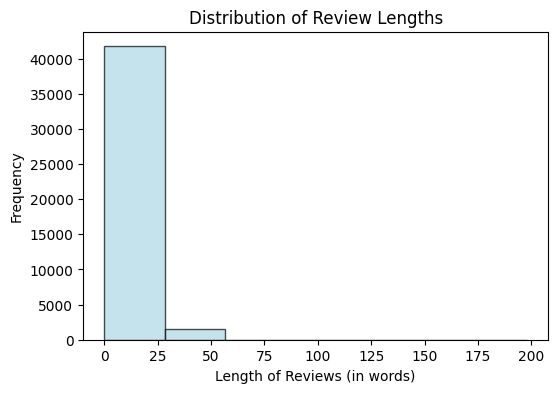

In [12]:
import matplotlib.pyplot as plt
review_lengths = [len(review) for review in cleaned_reviews]

plt.figure(figsize=(6, 4))
plt.hist(review_lengths, bins=7, color='lightblue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Length of Reviews (in words)")
plt.ylabel("Frequency")
plt.show()

In [29]:
import numpy as np
# 리뷰 길이 리스트에서 85번째 백분위수 계산
percentile_85 = np.percentile(review_lengths, 85)
print(percentile_85)
maxlen = int(percentile_85)

20.0


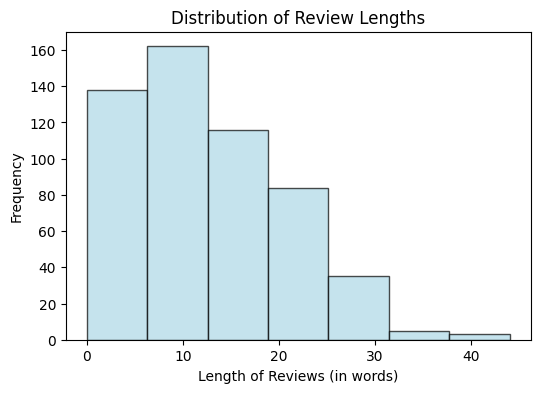

In [14]:
review_lengths_test = [len(review) for review in cleaned_reviews_test]

plt.figure(figsize=(6, 4))
plt.hist(review_lengths_test, bins=7, color='lightblue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Length of Reviews (in words)")
plt.ylabel("Frequency")
plt.show()

In [15]:
import numpy as np
# 리뷰 길이 리스트에서 80번째 백분위수 계산
percentile_80 = np.percentile(review_lengths_test, 80)
print(percentile_80)

20.0


20 글자로 제한해서 긴 리뷰에 의한 노이즈를 제거하고 훈련 속도를 개선한다.

**Keras는 단어를 정수로 처리하기 때문에, Word2Vec의 단어와 Keras 인덱스를 연결하는 작업이 필요함**

ex) cleaned_reviews = [["the", "dog", "barked"], ["a", "cat", "meowed"]]

word_index = {"the": 1, "dog": 2, "barked": 3, "a": 4, "cat": 5, "meowed": 6}

train_sequences = [[1, 2, 3], [4, 5, 6]]


In [80]:
# 1. train data: 단어 -> idxing
word_index = {word: i+1 for i, word in enumerate(model.wv.index_to_key)}
vocab_size = len(word_index) + 1
print(dict(list(word_index.items())[:5]))

{'game': 1, 'com': 2, 'like': 3, 'pic': 4, 'twitter': 5}


In [81]:
# 2. test data: 단어 -> idxing
word_index_test = {word: i+1 for i, word in enumerate(model_test.wv.index_to_key)}
vocab_size_test = len(word_index_test) + 1
print(dict(list(word_index_test.items())[:5]))

{'com': 1, 'game': 2, 'twitter': 3, 'pic': 4, 'like': 5}


In [35]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 3. embedding matrix 생성
# 1) train + test 합치기
combined_vocab = set(word_index.keys()).union(set(word_index_test.keys()))
vocab_size_combined = len(combined_vocab) + 1  # +1은 패딩
word_index_combined = {word: i + 1 for i, word in enumerate(combined_vocab)}

In [57]:
# 2) embedding_matrix_combined 초기화
embedding_matrix_combined = np.zeros((vocab_size_combined, embedding_dim))

# 2-1) Train Word2Vec의 벡터를 embedding_matrix_combined에 추가
for word, idx in word_index_combined.items():
    if word in model.wv:  # Train Word2Vec에 존재하는 단어
        embedding_matrix_combined[idx] = model.wv[word]

# 2-2) Test Word2Vec의 벡터를 embedding_matrix_combined에 추가
for word, idx in word_index_combined.items():
    if word in model_test.wv and np.all(embedding_matrix_combined[idx] == 0):
        embedding_matrix_combined[idx] = model_test.wv[word]

# 확인
print(f"Embedding matrix shape: {embedding_matrix_combined.shape}")

Embedding matrix shape: (11049, 100)


In [ ]:
# 4. word_index_combined에 있는 단어들로만 구성되도록
def text_to_sequence(texts, word_index_combined):
    sequences = []
    for text in texts:
        seq = [word_index_combined[word] for word in text if word in word_index_combined]
        sequences.append(seq)
    return sequences

# 4-1) Train과 Test 데이터 텍스트를 시퀀스로 변환
train_sequences = text_to_sequence(cleaned_reviews, word_index_combined)
test_sequences = text_to_sequence(cleaned_reviews_test, word_index_combined)

# 5. seq->padding
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')
train_padded = np.array(train_padded, dtype=np.int32)  # 정수형 배열
labels = np.array(labels, dtype=np.float32)           # 실수형 배열

test_padded = np.array(test_padded, dtype=np.int32)  # 정수형 배열
labels_test = np.array(labels_test, dtype=np.float32)  # 실수형 배열

In [51]:
# 확인
print(f"Train padded shape: {train_padded.shape}")
print(f"Test padded shape: {test_padded.shape}")

vocab_size = len(embedding_matrix_combined)
print(vocab_size)

Train padded shape: (43373, 20)
Test padded shape: (543, 20)
11049


**2. model 생성**

In [52]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

lstm_model = Sequential()
lstm_model.add(Embedding(
    input_dim=vocab_size,  # 단어 집합 크기
    output_dim=embedding_dim,  # 임베딩 벡터 크기
    weights=[embedding_matrix_combined],  # 사전 학습된 임베딩 가중치
    trainable=False,  # 임베딩 고정 (학습하지 않음)
    mask_zero=True
))

lstm_model.add(keras.layers.LSTM(8, return_sequences=True, kernel_initializer='glorot_uniform' )) #과적합 시 dropout=0.3 해보기
lstm_model.add(keras.layers.LSTM(8))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [53]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.build(input_shape=(None, maxlen))

In [54]:
lstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 20, 100)        │     1,104,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 20, 8)          │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,108,941 (4.23 MB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 1,104,900 (4.21 MB)

embedding_dim으로 작은 데이터 셋은 50~100, 중간 데이터 셋은 100~200, 대규모 데이터 셋은 200~300이 적당하다.

**3. 성능 평가**

2개 이상의 모델 Hyper Parameter 조합에 따른 모델 성능 평가 및 분석

In [55]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('lstm_model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history= lstm_model.fit(train_padded, labels, epochs=100, batch_size = 64,callbacks=[checkpoint_cb, early_stopping_cb], \
                       validation_data=(test_padded, labels_test))

Epoch 1/100
678/678 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6989 - loss: 0.5771 - val_accuracy: 0.7956 - val_loss: 0.4675
Epoch 2/100
678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7627 - loss: 0.4915 - val_accuracy: 0.8085 - val_loss: 0.4434
Epoch 3/100
678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7692 - loss: 0.4725 - val_accuracy: 0.8140 - val_loss: 0.4209
Epoch 4/100
678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7734 - loss: 0.4669 - val_accuracy: 0.7901 - val_loss: 0.4265
Epoch 5/100
678/678 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7746 - loss: 0.4580 - val_accuracy: 0.8011 - val_loss: 0.4144
Epoch 6/100
678/678 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7791 - loss: 0.4543 - val_accuracy: 0.8103 - val_loss: 0.3988
Epoch 7/100
678/678 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7873 - loss: 0.4427 - val_accuracy: 0.8269 - val_loss: 0.3985
Epoch 8/100
678/678 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7827 - loss: 0.4458 - va

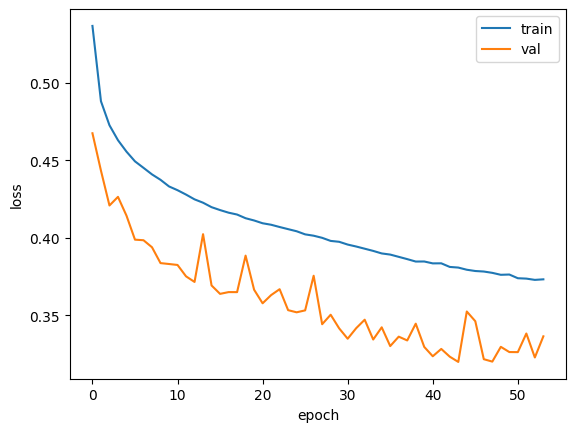

In [56]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

validation data의 loss와 test data의 loss 차이가 크지 않으며, 두 값이 비슷한 형태로 감소한다. 

모델이 과적합되지 않고 적절히 일반화 된 것을 볼 수 있다. 이는 embedding matrix로 인한 효과로 보인다.

**(2) LSTM(8) -> LSTM(64)로 변경하여 LSTM 레이어의 출력 차원을 바꾼다. dropout=0.3으로 과적합 방지**

이를 통해 더 많은 정보를 학습할 수 있다. 최적값에 더 가깝게 도달하도록 Adam의 learning_rate는 0.001로 변경 없이 유지한다.

epoch는 50, batch size는 32로 감소해 과적합을 피하고 훈련 속도를 조절한다.

dropout=0.3으로 과적합을 막는다.

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

lstm_model = Sequential()
lstm_model.add(Embedding(
    input_dim=vocab_size,  # 단어 집합 크기
    output_dim=embedding_dim,  # 임베딩 벡터 크기
    weights=[embedding_matrix_combined],  # 사전 학습된 임베딩 가중치
    trainable=False,  # 임베딩 고정 (학습하지 않음)
    mask_zero=True
))

lstm_model.add(keras.layers.LSTM(64, return_sequences=True, dropout=0.3, kernel_initializer='glorot_uniform' )) #과적합 시 dropout
lstm_model.add(keras.layers.LSTM(64))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [71]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.build(input_shape=(None, maxlen))
lstm_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 20, 100)        │     1,104,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 20, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,180,229 (4.50 MB)

 Trainable params: 75,329 (294.25 KB)

 Non-trainable params: 1,104,900 (4.21 MB)

In [73]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('lstm_model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history= lstm_model.fit(train_padded, labels, epochs=50, batch_size = 32,callbacks=[checkpoint_cb, early_stopping_cb], \
                       validation_data=(test_padded, labels_test))

Epoch 1/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.8639 - loss: 0.2903 - val_accuracy: 0.9153 - val_loss: 0.2385
Epoch 2/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.8740 - loss: 0.2726 - val_accuracy: 0.9208 - val_loss: 0.2208
Epoch 3/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.8785 - loss: 0.2656 - val_accuracy: 0.9153 - val_loss: 0.1854
Epoch 4/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.8862 - loss: 0.2516 - val_accuracy: 0.9227 - val_loss: 0.2166
Epoch 5/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.8839 - loss: 0.2487 - val_accuracy: 0.9282 - val_loss: 0.1924
Epoch 6/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.8934 - loss: 0.2343 - val_accuracy: 0.9208 - val_loss: 0.1970
Epoch 7/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.8941 - loss: 0.2315 - val_accuracy: 0.9411 - val_loss: 0.1784
Epoch 8/50
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.8982 -

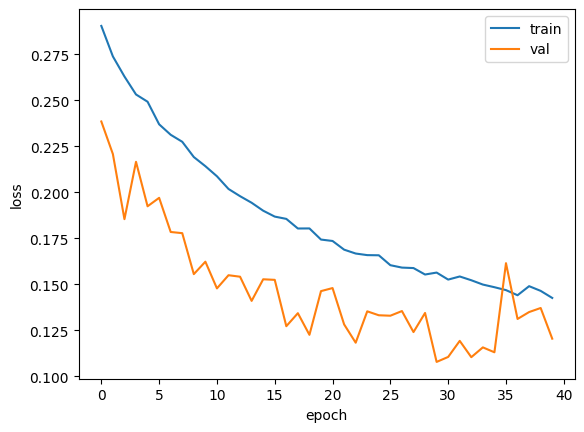

In [74]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

-첫번째 그래프

678/678 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8262 - loss: 0.3718 - val_accuracy: 0.8490 - val_loss: 0.3364

-현재 그래프

1356/1356 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.9371 - loss: 0.1387 - val_accuracy: 0.9632 - val_loss: 0.1204

으로 train data는 0.8262 -> 0.9371, test data는 0.8490 -> 0.9632로 유의미하게 증가하였다.

LSTM layer의 출력 차원 변경과 epoch, batch_size, dropout의 변화가 효과가 있었던 것으로 보인다.


**+) 추가**

<img src="dropout_x.png" alt="description" width="500"/>

위의 그림은 droupout=0.3을 사용하지 않은 사진이다. loss가 0.2 미만으로 매우 감소했으나 epoch이 15 이후로 validation data가 증가하여 과적합이 발생했다.

이에 따라 2번째 model에서 dropout을 지정해주었다.
